In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import rubin_sim.maf.db as db
import rubin_sim.maf.utils as utils
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.stackers as stackers
import rubin_sim.maf.metricBundles as metricBundles
import rubin_sim.maf.plots as plots
import pandas as pd

In [2]:
# XXX-- a very simple placeholder function. Simple top-hat. Feel free to modify so it's a trapezoid or other shape

def blazar_lc(mjd, filternames, mag, period, platue_time,
              burst_mag, rise_time=0, phase=0):
    
    # XXX--note I'm passing in the filtername info but not using it. Probably want to set some default colors
    # and apply to the results
    result = mjd*0 + mag
    all_phase = (mjd + phase) % period
    
    outbursting = np.where(all_phase <= platue_time)
    result[outbursting] -= burst_mag
    
    return result



    

In [3]:
# Let's make a class that loads up example light curves
class Blazar_lc(object):
    def __init__(self):
        files = ['g1101r_offset.ord', 'g2251r_offset.ord']
        self.lcs = {}
        types = [float, float, float, '|U20']
        names = ['mjd', 'mag', 'something', 'foo']

        self.lc_lengths = []
        for i,filename in enumerate(files):
            self.lcs[i] = np.genfromtxt(filename, dtype=list(zip(names,types)))
            # subtract off the median
            self.lcs[i]['mag'] -= np.median(self.lcs[i]['mag'])
            self.lc_lengths.append(self.lcs[i]['mjd'].max() - self.lcs[i]['mjd'].min())
        
    def __call__(self, mjd, filternames, filenum):
        # Can expand here to include color information. For now, just ignore the filter
        # Use the period kwarg so this should just wrap if we have a larger MJD than what's in the data.
        mag_out = np.interp(mjd, self.lcs[filenum]['mjd'], self.lcs[filenum]['mag'],
                             period=self.lc_lengths[filenum])
        return mag_out

(17.0, 13.5)

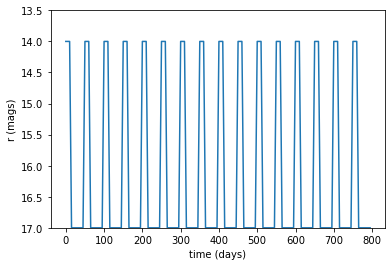

In [4]:
# make sure the blazar light curve looks ok
mjd = np.arange(0,800, 5)
plt.plot(mjd, blazar_lc(mjd, 'r', 17., 50., 10., 3.))
plt.xlabel('time (days)')
plt.ylabel('r (mags)' )
plt.ylim([17, 13.5])

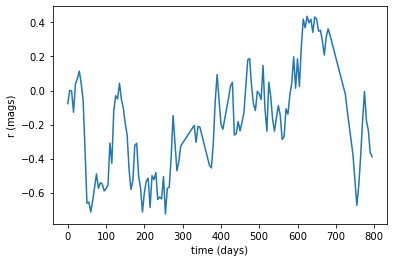

In [5]:
# try out the new blazar_lc object
blc = Blazar_lc()
plt.xlabel('time (days)')
plt.ylabel('r (mags)' )
plt.plot(mjd, blc(mjd, 'r', 0))

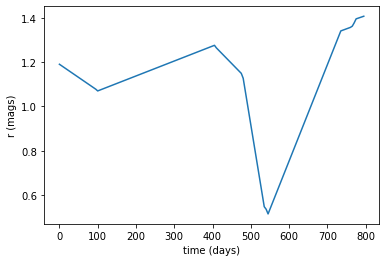

In [6]:
blc = Blazar_lc()
plt.xlabel('time (days)')
plt.ylabel('r (mags)' )
plt.plot(mjd, blc(mjd, 'r', 1))

In [7]:
blc.lcs

{0: array([(2454412.6916 , 0.3285, 0.02, 'WEBT'),
        (2454412.69484, 0.3385, 0.02, 'WEBT'),
        (2454413.68425, 0.3525, 0.02, 'WEBT'), ...,
        (2457934.64802, 0.5915, 0.02, 'STEWARD'),
        (2457935.64925, 0.6115, 0.02, 'STEWARD'),
        (2457936.64818, 0.6015, 0.02, 'STEWARD')],
       dtype=[('mjd', '<f8'), ('mag', '<f8'), ('something', '<f8'), ('foo', '<U20')]),
 1: array([(2448103.571 , 1.024, 0.01, 'WEBT'),
        (2448159.466 , 1.112, 0.01, 'WEBT'),
        (2448160.46  , 1.114, 0.01, 'WEBT'), ...,
        (2458096.6878, 0.506, 0.14, 'KAIT'),
        (2458097.58  , 0.476, 0.19, 'KAIT'),
        (2458098.6228, 0.576, 0.12, 'KAIT')],
       dtype=[('mjd', '<f8'), ('mag', '<f8'), ('something', '<f8'), ('foo', '<U20')])}

In [8]:
def generateBlazarSlicer(filename, seed=42):
    """Generate a bunch of blazar objects
    """
    # set the seed so things are repeatable
    np.random.seed(seed)
    # read in some data:
    columns = ['ra', 'dec', 'mag', 'period', 'rise_time', 'platue_time', 'burst_mag']
    
    blazar_data = pd.read_csv('blazars.dat', names=columns, comment='#', index_col=False)
    
    slicer = slicers.UserPointsSlicer(blazar_data['ra'].values,
                                      blazar_data['dec'].values,
                                      latLonDeg=True, badval=0)
    # Put all the blazar info into the slicePoint dict
    for col in columns[2:]:
        slicer.slicePoints[col] = blazar_data[col].values
        
    # add a slicePoint for filenum
    nfiles = 2
    slicer.slicePoints['filenum'] = np.round(np.random.rand(blazar_data['ra'].values.size)*(nfiles-1)).astype(int)
    
    # randomize the phase of each blazar
    slicer.slicePoints['phase'] = blazar_data['period'].values * np.random.uniform(size=slicer.nslice)
    
    return slicer

In [9]:
class BlazarMetric(metrics.BaseMetric):
    """
    """
    
    def __init__(self,  metricName='BlazarMetric', mjdCol='observationStartMJD', m5Col='fiveSigmaDepth',
                 filterCol='filter', **kwargs):
        self.mjdCol = mjdCol
        self.m5Col = m5Col
        self.filterCol = filterCol
        self.saturationCol = 'saturation_mag'
        
        cols = [self.mjdCol, self.m5Col, self.filterCol, self.saturationCol]
        self.lcs = Blazar_lc()
        super(BlazarMetric, self).__init__(col=cols, units='Detected, 0 or 1',
                                           metricName=metricName, **kwargs)
        
    def run(self, dataSlice, slicePoint=None):
        
        # Dictionary to hold results
        result = {}
        
        # Generate the lightcurve
        lc = self.lcs(dataSlice[self.mjdCol], dataSlice[self.filterCol], slicePoint['filenum'])
        
        # Maybe say the mag is the offset from our example lightcurve
        lc += slicePoint['mag']
        
        # XXX--we could apply dust extintion here. Skipping for now
        
        # Points that are above 5-sigma depth
        diff = lc - dataSlice[self.m5Col]
        bright_enough = np.where(diff < 0)[0]
        
        # Points that saturated
        diff = lc - dataSlice['saturation_mag']
        saturated_indx = np.where(diff < 0)[0]
        unsaturated = np.where(diff > 0)[0]
        
        good_photometry = np.intersect1d(bright_enough, unsaturated)
        # do we detect that this object is variable?
        # I'll use the very simple criteria that we have good photometry that
        # shows a 0.5 mag change in brightness. 
        result['variable_detected'] = 0
        if np.size(good_photometry) > 0:
            if (lc[good_photometry].max() - lc[good_photometry].min()) > 0.5:
                result['variable_detected'] = 1
            
        # Did we saturate
        result['frac_saturated'] = 0
        if np.size(saturated_indx) > 0:
            result['frac_saturated'] = np.size(saturated_indx)/np.size(dataSlice)
            
        # Could add many more criteria. Things like, was it detected early enough to 
        # trigger follow-up events, is there enough data to classify in a timely manner, etc.
      
        return result
    
    # When we calculate multiple values in a metric, give each one a "reduce" method.
    def reduce_detected(self, metric):
        return metric['variable_detected']
    def reduce_saturated(self, metric):
        return metric['frac_saturated']

In [10]:
# conenct to the simulation database
dbFile = 'baseline_nexp2_v1.7_10yrs.db'
runName = dbFile.replace('.db', '')
conn = db.OpsimDatabase(dbFile)
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)


In [11]:
bundleList = []
sql = ''
# Let's plug in the magnitudes for one type
metric = BlazarMetric()
slicer = generateBlazarSlicer('blazars.dat')

summaryMetrics=[metrics.MeanMetric(maskVal=0)]
plotDict = {}
#plotFuncs = [plots.HealpixSkyMap()]
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict,
                                             summaryMetrics=summaryMetrics,
                                             runName=runName))

Querying database SummaryAllProps with no constraint for columns ['visitExposureTime', 'fieldDec', 'filter', 'airmass', 'seeingFwhmEff', 'fieldRA', 'fiveSigmaDepth', 'rotSkyPos', 'observationStartMJD', 'skyBrightness', 'numExposures'].
Found 2045493 visits
Running:  ['baseline_nexp2_v1_7_10yrs_BlazarMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/plots/plotHandler.py:518: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn('Cannot plot object metric values with this plotter.')
/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/plots/spatialPlotters.py:344: UserWarning: Histogram range was single-valued; expanding default range.
  warnings.warn('Histogram range was single-valued; expanding default range.')
/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:97: RuntimeWarning: invalid value encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:105: UserWarning: Optimal bin calculation calculated NaN: returning 200
  warnings.warn('Optimal bin calculation calculated NaN: returning %i' %(nbinMax))
/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/plots/spatialPlotters.py:344: UserWarning: Histogram range was single-valued; expanding default range.
  warnings.war

Plotting complete.


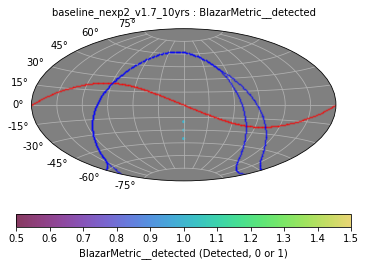

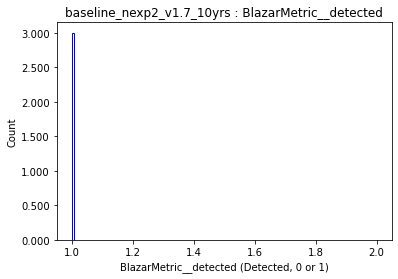

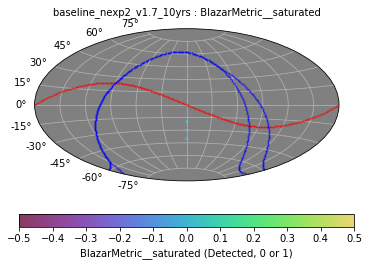

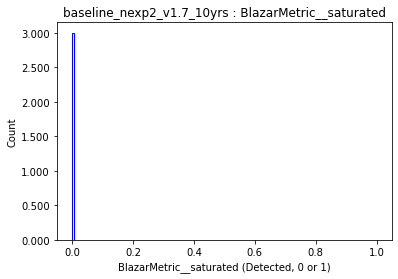

In [12]:


bd = metricBundles.makeBundlesDictFromList(bundleList)
bgroup = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)



In [13]:
bd

{'baseline_nexp2_v1_7_10yrs_BlazarMetric_USER': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x143e3ed00>,
 'BlazarMetric__detected': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x143c83a00>,
 'BlazarMetric__saturated': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x10dc196d0>}

In [14]:
# We can look at the summary stats. Basically the fraction of objects that got detected as variable, and 
# the mean fraction of saturated points.
bd['BlazarMetric__detected'].summaryValues, bd['BlazarMetric__saturated'].summaryValues

({'Mean': 0.75}, {'Mean': 0.0})

# Now let's see what lightcurves looks like

In [15]:
# Let's generate a lightcurve as it was seen
bundleList = []
sql = ''
# Use the PassMetric to just get the data at that point
metric = metrics.PassMetric(cols=['fiveSigmaDepth', 'observationStartMJD','filter'])
slicer = generateBlazarSlicer('blazars.dat')

    
plotDict = {}
#plotFuncs = [plots.HealpixSkyMap()]
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict,
                                             summaryMetrics=[],
                                             runName=runName))

bd = metricBundles.makeBundlesDictFromList(bundleList)
bgroup = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)




Querying database SummaryAllProps with no constraint for columns ['fieldDec', 'filter', 'fiveSigmaDepth', 'rotSkyPos', 'fieldRA', 'observationStartMJD'].
Found 2045493 visits
Running:  ['baseline_nexp2_v1_7_10yrs_Pass_fiveSigmaDepth_observationStartMJD_filter_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.
Plotting complete.


/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/plots/plotHandler.py:518: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn('Cannot plot object metric values with this plotter.')


In [16]:
# Here's all the info obout observations that overlapped that spot in the sky
bundleList[0].metricValues

masked_array(data=[array([(-20.87119127, 'z', 22.8701956 , 300.47295981, 3.58867842e+02, 60546.347425  ),
                          (-21.2938007 , 'u', 23.21616806, 100.56224993, 3.59018922e+02, 62747.15832206),
                          (-20.89071499, 'u', 23.31237857, 304.0218046 , 3.58654368e+02, 61709.13837369),
                          (-20.87119127, 'y', 22.09925943, 302.43251009, 3.58867842e+02, 60546.36385683),
                          (-20.88367014, 'z', 23.07073822, 124.16614098, 3.58418382e+02, 62338.31220137),
                          (-20.92295587, 'r', 24.3010774 , 190.46954203, 3.58971481e+02, 63418.43951074),
                          (-20.93819069, 'z', 22.83026647, 317.48260288, 3.58529338e+02, 62732.36429688),
                          (-20.83308581, 'z', 22.7592126 , 192.1818866 , 3.58682554e+02, 63199.09958015),
                          (-21.01431182, 'y', 21.90215185, 169.28164396, 3.58349382e+02, 61551.41030986),
                          (-21.20443273, 'r', 

No data for object 3


Text(0, 0.5, 'mags')

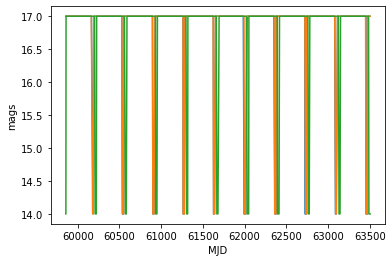

In [17]:
# now we can pass that to the light curve function and see what it looks like
for i,mv in enumerate(bundleList[0].metricValues):
    if np.size(mv) > 1:
        mv.sort(order='observationStartMJD')
        lc = blazar_lc(mv['observationStartMJD'], mv['filter'],
                       slicer.slicePoints['mag'][i], slicer.slicePoints['period'][i],
                       slicer.slicePoints['platue_time'][i],
                      slicer.slicePoints['burst_mag'][i], rise_time=0, phase=slicer.slicePoints['phase'][i])
        plt.plot(mv['observationStartMJD'], lc, label=i)
    else:
        print('No data for object %i' % i)
plt.xlabel('MJD')
plt.ylabel('mags')